In [13]:
import importlib
import models
importlib.reload(models)
from models import ButlerVolmer, TafelData
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Data Summary:
  Number of points: 37
  Eta range: -0.0156 to 0.0148 V
  ln(k) range: -8.6713 to -5.1573
  k range: 1.714278e-04 to 5.757204e-03

First few rows:
        eta       lnk         k
0 -0.015618 -5.646067  0.003531
1 -0.014884 -5.688202  0.003386
2 -0.014088 -5.797753  0.003034
3 -0.013291 -5.873596  0.002813
4 -0.012494 -5.882022  0.002789


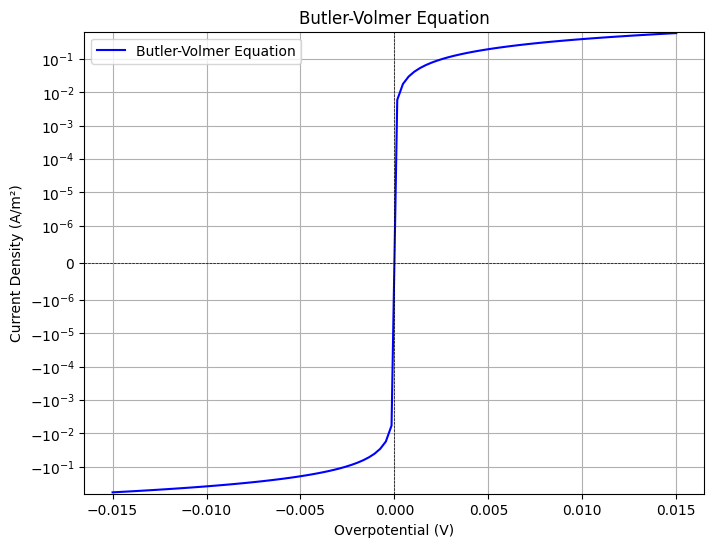

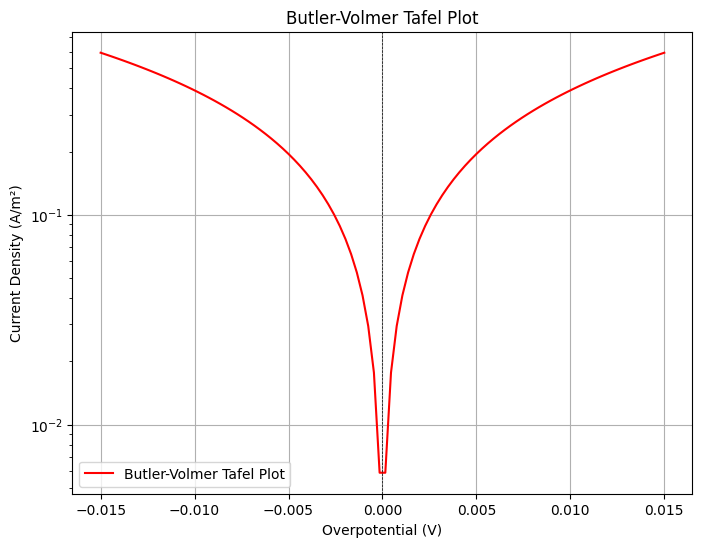

In [14]:
# Load and process experimental data using TafelData class
tafel_data = TafelData('Cell-A-Tafel.csv')
data = tafel_data.load_and_process()

# Display summary
tafel_data.get_summary()

# Plot Butler-Volmer curves
ButlerVolmer(i0=1).plot_bulter_volmer()
ButlerVolmer(i0=1).plot_tafel()

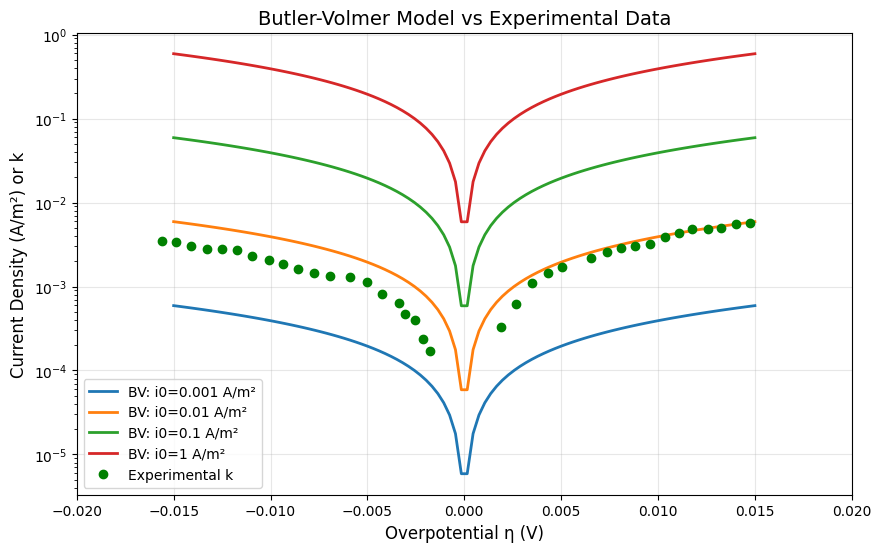

In [15]:
# Plot experimental data vs Butler-Volmer models with different i0 values
plt.figure(figsize=(10, 6))

# Plot Butler-Volmer curves for different i0 values
for i0_i in [0.001, 0.01, 0.1, 1]:
    eta, i = ButlerVolmer(i0=i0_i).current_density()
    plt.semilogy(eta, np.abs(i), label=f'BV: i0={i0_i} A/m²', linewidth=2)

# Plot experimental data (ln(k) on log scale)
# Since ln(k) represents log of rate constant, exp(lnk) gives relative current
plt.semilogy(data['eta'], data['k'], 'o', label='Experimental k', color='green', markersize=6)

plt.xlabel('Overpotential η (V)', fontsize=12)
plt.ylabel('Current Density (A/m²) or k', fontsize=12)
plt.title('Butler-Volmer Model vs Experimental Data', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()
plt.xlim(-0.02, 0.02)  # Focus on region near zero
plt.show()

C:\Users\felix\AppData\Local\Temp\ipykernel_6584\3372233360.py:5: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0, 1e-1)


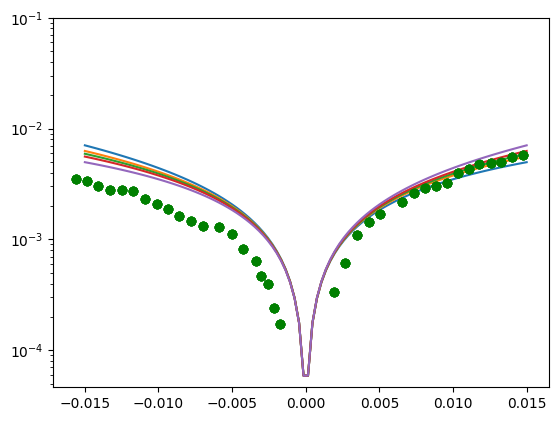

In [16]:
for alpha_i in [0.2, 0.4, 0.5, 0.6, 0.8]:
    eta, i = ButlerVolmer(i0=0.01, alpha=alpha_i).current_density()
    plt.semilogy(eta, np.abs(i), label=f'alpha={alpha_i}')
    plt.semilogy(data['eta'], data['k'], 'o', label='Experimental Data', color='green')
    plt.ylim(0, 1e-1)

Fitted Parameters:
  i0 (exchange current density) = 6.352675e-03 A/m²
  α (transfer coefficient) = 0.9000

Parameter uncertainties (std dev):
  i0 uncertainty = 3.021157e-04
  α uncertainty = 0.1303


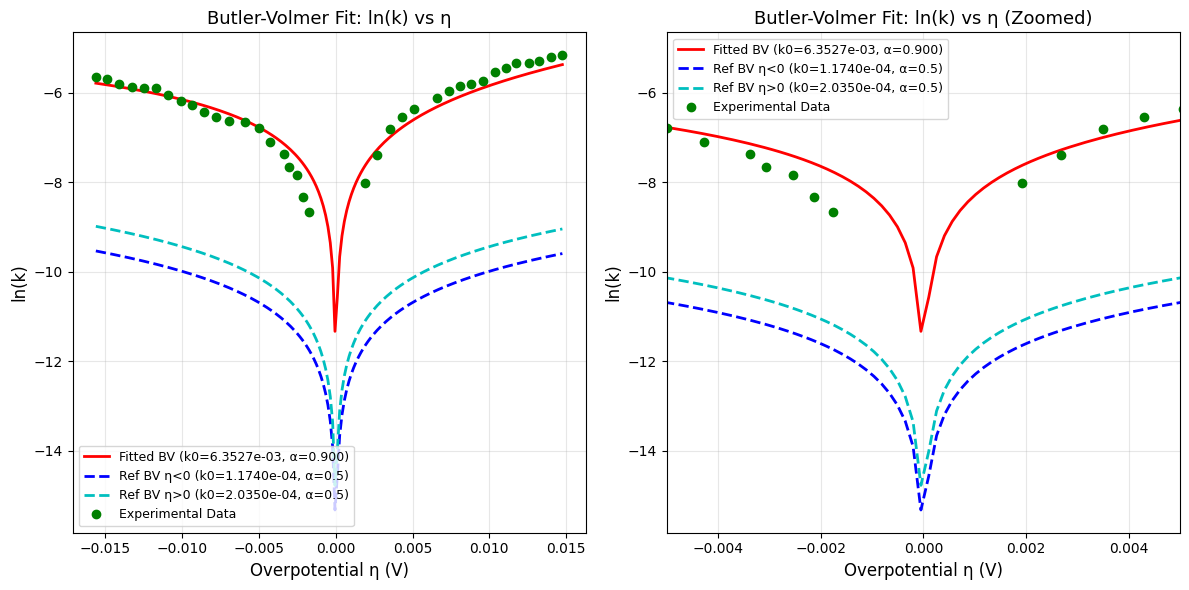

In [ ]:
# Fit Butler-Volmer model to experimental data
from scipy.optimize import curve_fit

# Define Butler-Volmer function for fitting (returns ln(k))
def bv_fit_function_lnk(eta, i0, alpha):
    """Butler-Volmer equation for curve fitting - returns ln(abs(i))"""
    F = 96485.3329  # Faraday constant, C/mol
    R = 8.314462618  # Gas constant, J/(mol·K)
    n = 1
    T = 298.15
    
    i = i0 * (np.exp((alpha * n * F * eta) / (R * T)) - 
              np.exp((-(1 - alpha) * n * F * eta) / (R * T)))
    return np.log(np.abs(i))

# Prepare data for fitting
eta_data = data['eta'].values
lnk_data = data['lnk'].values

# Initial guess for parameters [i0, alpha]
initial_guess = [0.003, 0.5]

# Perform curve fitting
try:
    popt, pcov = curve_fit(bv_fit_function_lnk, eta_data, lnk_data, 
                           p0=initial_guess, 
                           bounds=([1e-6, 0.1], [1.0, 0.9]),
                           maxfev=10000)
    
    i0_fit, alpha_fit = popt
    
    print(f"Fitted Parameters:")
    print(f"  i0 (exchange current density) = {i0_fit:.6e} A/m²")
    print(f"  α (transfer coefficient) = {alpha_fit:.4f}")
    print(f"\nParameter uncertainties (std dev):")
    print(f"  i0 uncertainty = {np.sqrt(pcov[0,0]):.6e}")
    print(f"  α uncertainty = {np.sqrt(pcov[1,1]):.4f}")
    
    # Plot fitted model vs experimental data
    plt.figure(figsize=(12, 6))
    
    # Generate model predictions
    eta_model = np.linspace(data['eta'].min(), data['eta'].max(), 200)
    lnk_fitted = bv_fit_function_lnk(eta_model, i0_fit, alpha_fit)
    
    # Reference values from literature (η < 0)
    k0_ref_neg = 1.174e-4  # s^-1 for η < 0
    alpha_ref = 0.5
    lnk_ref_neg = bv_fit_function_lnk(eta_model, k0_ref_neg, alpha_ref)
    
    # Reference values from literature (η > 0)
    k0_ref_pos = 2.035e-4  # s^-1 for η > 0
    lnk_ref_pos = bv_fit_function_lnk(eta_model, k0_ref_pos, alpha_ref)
    
    # Subplot 1: Full range
    plt.subplot(1, 2, 1)
    plt.plot(eta_model, lnk_fitted, 'r-', linewidth=2, label=f'Fitted BV (k0={i0_fit:.4e}, α={alpha_fit:.3f})')
    plt.plot(eta_model, lnk_ref_neg, 'b--', linewidth=2, label=f'Ref BV η<0 (k0={k0_ref_neg:.4e}, α=0.5)')
    plt.plot(eta_model, lnk_ref_pos, 'c--', linewidth=2, label=f'Ref BV η>0 (k0={k0_ref_pos:.4e}, α=0.5)')
    plt.plot(data['eta'], data['lnk'], 'go', markersize=6, label='Experimental Data')
    plt.xlabel('η (V)', fontsize=12)
    plt.ylabel('Ln(k/s⁻¹)', fontsize=12)
    plt.title('Butler-Volmer Fit: Ln(k/s⁻¹) vs η', fontsize=13)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=9)
    
    # Subplot 2: Zoomed in near zero
    plt.subplot(1, 2, 2)
    plt.plot(eta_model, lnk_fitted, 'r-', linewidth=2, label=f'Fitted BV (k0={i0_fit:.4e}, α={alpha_fit:.3f})')
    plt.plot(eta_model, lnk_ref_neg, 'b--', linewidth=2, label=f'Ref BV η<0 (k0={k0_ref_neg:.4e}, α=0.5)')
    plt.plot(eta_model, lnk_ref_pos, 'c--', linewidth=2, label=f'Ref BV η>0 (k0={k0_ref_pos:.4e}, α=0.5)')
    plt.plot(data['eta'], data['lnk'], 'go', markersize=6, label='Experimental Data')
    plt.xlabel('η (V)', fontsize=12)
    plt.ylabel('Ln(k/s⁻¹)', fontsize=12)
    plt.title('Butler-Volmer Fit: Ln(k/s⁻¹) vs η (Zoomed)', fontsize=13)
    plt.xlim(-0.005, 0.005)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"Fitting failed: {e}")
    print("Try adjusting initial guesses or bounds.")

In [16]:
import numpy as np
C = np.log(3)
np.exp(C)
3/(1+np.exp(C))-1/(1+np.exp(-C))

np.float64(0.0)

C:\Users\felix\AppData\Local\Temp\ipykernel_6584\4118059888.py:24: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go" (-> color='g'). The keyword argument will take precedence.
  plt.plot(cell_data['eta'], cell_data['lnk'], 'go',
C:\Users\felix\AppData\Local\Temp\ipykernel_6584\4118059888.py:24: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go" (-> color='g'). The keyword argument will take precedence.
  plt.plot(cell_data['eta'], cell_data['lnk'], 'go',
C:\Users\felix\AppData\Local\Temp\ipykernel_6584\4118059888.py:24: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go" (-> color='g'). The keyword argument will take precedence.
  plt.plot(cell_data['eta'], cell_data['lnk'], 'go',


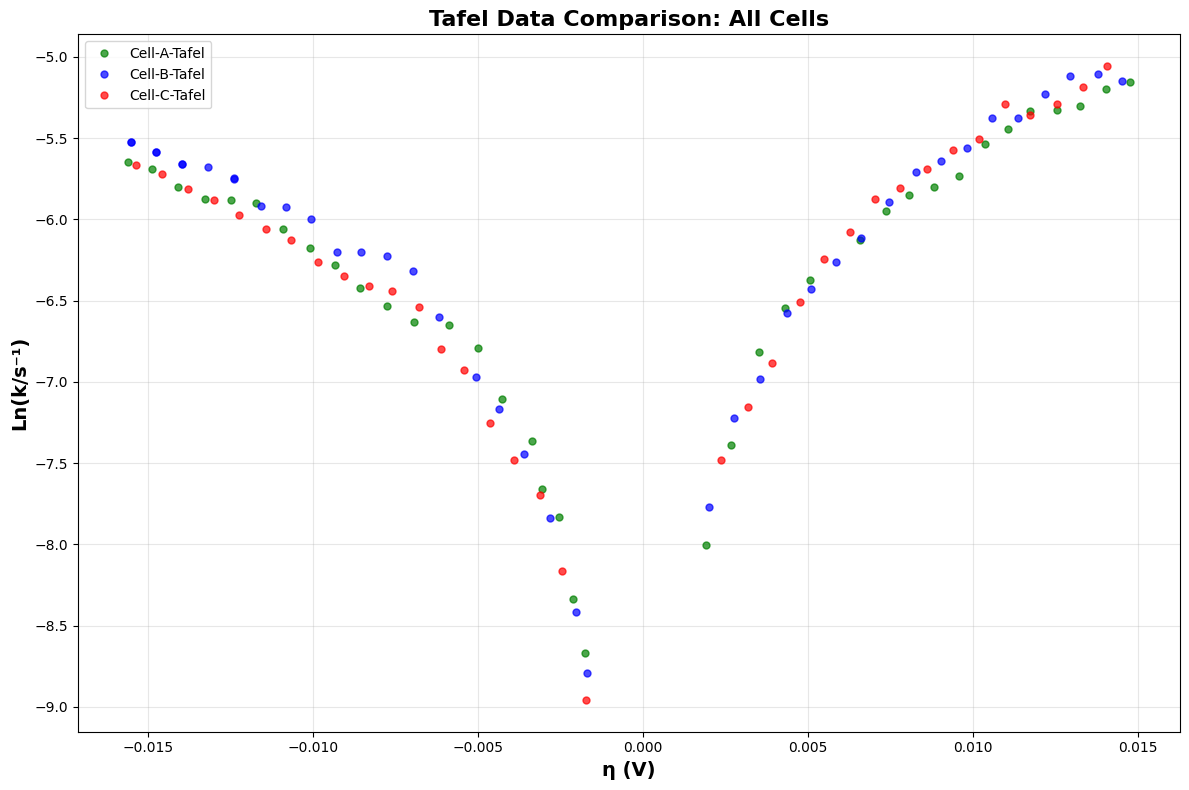

In [22]:
# Plot all CSV files in the folder
import os
import glob

# Find all CSV files
csv_files = glob.glob('*.csv')

# Create figure
plt.figure(figsize=(12, 8))

# Colors for different cells
colors = ['green', 'blue', 'red', 'purple', 'orange']

# Plot each CSV file
for idx, csv_file in enumerate(csv_files):
    # Load and process data
    tafel = TafelData(csv_file)
    cell_data = tafel.load_and_process()
    
    # Extract cell name from filename
    cell_name = os.path.splitext(csv_file)[0]
    
    # Plot
    plt.plot(cell_data['eta'], cell_data['lnk'], 'go', 
             label=cell_name, color=colors[idx % len(colors)], 
             markersize=5, alpha=0.7)


plt.xlabel('η (V)', fontsize=14, fontweight='bold')
plt.ylabel('Ln(k/s⁻¹)', fontsize=14, fontweight='bold')
plt.title('Tafel Data Comparison: All Cells', fontsize=16, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()